# Create masks

The chars detection is provided in an xml file. Each char detection is described by its coordinates and size. Because we want to use algortithm like Mask-RCNN, we need to transform the given chars detection into binary masks. 

In [12]:
%run "../config/local.ipynb"
%run "../utils/functions.ipynb"

from random import randint
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm.notebook as tq
import math
import xml.etree.ElementTree as ET
import pandas as pd

from src.visualization.imagevisualization import visualize_labels

## Extract informations from the XML file

Many infomations are provided into the XML file such as words position, kind of words or chars location. We mainly concentrate on chars. Then, the following function extract all informations about chars from the XML file. 
We also calculate an ink ratio, an additionnal informations that could help to detect characters.

### Information extraction function 

In [2]:
def get_bboxes():
    items = []
    labels = os.listdir(XML_LABELS_DIR)
    
    # for each label file
    for i in tq.tqdm(range(len(labels)), total=len(labels)):    
        labelfile = labels[i]
        feature_name = labelfile.replace(".xml", "")
        img_path = os.path.join(ORIGINAL_FEATURES_DIR, feature_name + ".png")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # read the xml file
        tree = ET.parse(os.path.join(XML_LABELS_DIR, labelfile))
        root = tree.getroot()
        
        # parse the xml file and extract chars coordinates
        item = {}        
        num = 0
        for word in root.iter('word'):        
            for char in word.iter('cmp'):
                if int(char.attrib['width']) < 2000:
                    # read attributes
                    x, y = int(char.attrib['x']), int(char.attrib['y'])
                    width, height = int(char.attrib['width']), int(char.attrib['height'])
                    
                    # get ink amount
                    start_point = {"x": x, "y": y}
                    end_point = {"x": x + height, "y": y + width}
                    
                    patch = 255 - img[start_point['y']:end_point['y'], start_point['x']:end_point['x']]
                    ink_ratio = round(patch.sum() / np.full(patch.size, 255).sum(), 2)                    
                    
                    # set item 
                    item = {"name": feature_name, "num": num, "x": x, "y": y, "width": width, "height": height, "ink": ink_ratio}
                    items.append(item)
                    num += 1
    df = pd.DataFrame(items)        
    
    return df.set_index(['name', 'num'])

### Build the dataframe

In [ ]:
df_chars = get_bboxes()

### Load chars from disk

In [6]:
df_chars = pd.read_csv(LABELS_FILE)
df_chars = df_chars.set_index(['name', 'num'])

#### Check the generated chars dataframe

In [ ]:
df_chars.head()

#### Save the dataframe

In [10]:
df_chars.to_csv(LABELS_FILE)

### Display the result

#### Display function
Here we will create a function that will build and image of a page with its boundary boxes from the chars detection file.

In [11]:
def get_img_with_bboxes(feature, df):
    # retrieve the image
    img_path = os.path.join(ORIGINAL_FEATURES_DIR, feature + ".png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # to rgb
    img = np.stack((img,)*3, axis=-1)
    
    # get the labels
    df_feature_labels = df.loc[feature]
    
    for idx, row in df_feature_labels.iterrows():
        if row['ink'] > 0.00:
            color = (192, 48, 209, 100) 
            x, y = int(row['x']), int(row['y'])
            width, height = int(row['width']), int(row['height'])

            start_point = (x, y)
            end_point = (x + width, y + height)

            # img = cv2.rectangle(img, (10,10), (20,20), (0,0,0), 2)
            img = cv2.rectangle(img, start_point, end_point, color, 2)

            # font 
            font = cv2.FONT_HERSHEY_SIMPLEX 

            # org 
            pos = (x, int(y - 10))                             

            # fontScale 
            fontScale = 1

            # Line thickness of 2 px 
            thickness = 2        
            # Using cv2.putText() method 
            img = cv2.putText(img, str(row['ink']), pos, font, fontScale, color, thickness, cv2.LINE_AA) 

        
    return img

#### Execute the function

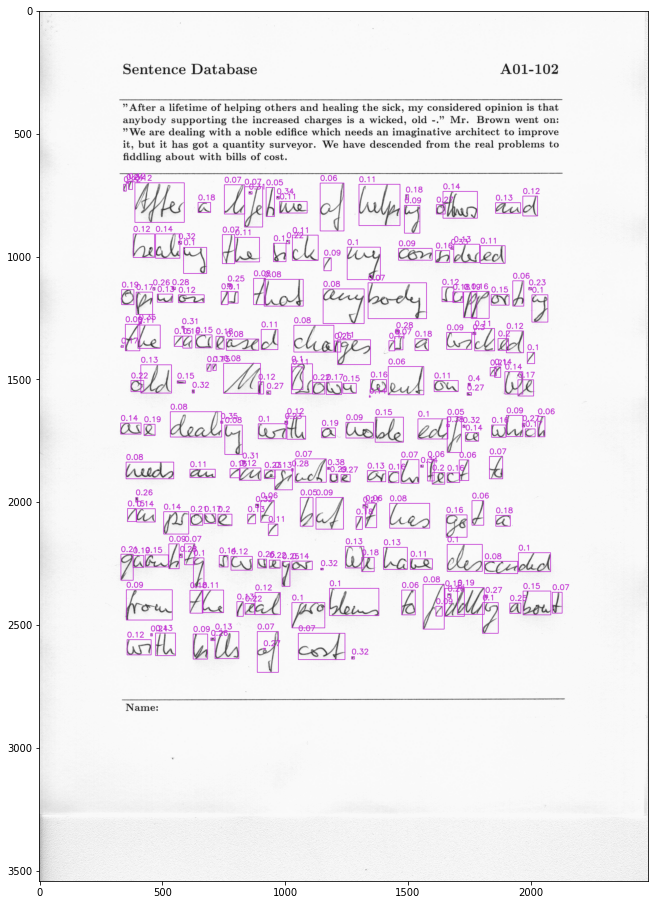

In [12]:
# randomly select a feature name
features = np.unique(list(df_chars.index.get_level_values('name')))
feature = features[randint(0, len(features))]

# generate the page with boudary boxes
img = get_img_with_bboxes(feature, df_chars)

# display the image
plt.figure(figsize=(16,16))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Create the masks

Now we have the informations we need, we need to calculate the masks from the chars informations. In the same time, we will resize the masks to a size that will make the learning of the algorithms more easy and invert the colors also to facilitate the learning.

### Creation function

In [7]:
def chars_masks(df, size=(512,512)):    
    df_result = df.copy()
    df_result['mask'] = ""    
    
    # unique names 
    names = np.unique(list(df.index.get_level_values('name')))
    
    for i, name in tq.tqdm(enumerate(names), total=len(names)):
        # read the page image
        img_path = os.path.join(ORIGINAL_FEATURES_DIR, name + ".png")
        page = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
         
        # get the labels
        df_img_labels = df.loc[name]
        for index, row in df_img_labels.iterrows():
            x, y = int(row['x']), int(row['y'])
            width, height = int(row['width']), int(row['height'])            
            start_point = (x, y)
            end_point = (x + width, y + height)
            
            # extract the char from the image
            patch = page[start_point[1]:end_point[1],start_point[0]:end_point[0]]        
            
            # invert colors
            patch = 255 - patch

            # binarize the char image            
            char_mask = patch.astype('uint8')
            char_mask = cv2.bilateralFilter(char_mask, 2, 88,15)
            char_mask = cv2.GaussianBlur(char_mask,(1,1),0)
            char_mask = cv2.adaptiveThreshold(char_mask, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 77, -3)

            # generate the mask
            mask = np.zeros(page.shape)            
            mask[start_point[1]:end_point[1], start_point[0]:end_point[0]] = char_mask
            
            # rescale the mask     
            resized = cv2.resize(mask, size, interpolation = cv2.INTER_NEAREST)            
            
            # RLE encoding of the mask
            df_result.loc[(name, index),'mask'] = rle_encoding(resized)
        
        df_result['label'] = 'char'
            
    return df_result

### Create the masks

In [9]:
df_masks = chars_masks(df_chars.iloc[:40000])

### Check the results

In [10]:
df_masks.head()

x    y  width  height   ink  \
name     num                                  
a01-000u 0    408  768     27      51  0.18   
         1    507  768     63      46  0.23   
         2    568  770     56      41  0.26   
         3    631  768     38      41  0.28   
         4    676  772     31      36  0.38   

                                                           mask label  
name     num                                                           
a01-000u 0              43633 6 44145 6 44658 6 45172 4 45685 3  char  
         1    53877 2 54385 6 54897 3 55411 2 55924 2 56436 ...  char  
         2    60530 3 61041 2 61045 1 61553 1 61557 1 62065 ...  char  
         3    67185 3 67698 4 68211 3 68724 2 69235 2 69745 ...  char  
         4    71795 3 72305 5 72819 1 72821 1 73329 1 73331 ...  char

### Save the labels

In [13]:
df_masks.to_csv(MASKS_FILE)

## Display some masks

### Load masks from disk file

In [14]:
df_masks = pd.read_csv(MASKS_FILE, index_col=['name', 'num'])
df_masks.fillna("", inplace=True)

In [19]:
def get_image_masks(df, feature=None):
    # randomly select a feature name    
    if not feature:
        features = np.unique(list(df.index.get_level_values('name')))
        feature = features[randint(0, len(features)-1)]

    # get image
    img_path = os.path.join(RESIZED_512x512_FEATURES_DIR, feature + ".png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = np.stack((img,)*3, axis=-1) 

    # get labels
    df_feature_labels = df.loc[feature]
    labels_count = len(list(df_feature_labels.index))
    masks = np.zeros((img.shape[0], img.shape[1]) + (labels_count,)).astype('uint8')

    # mask color and alpha value
    pink = (209, 48, 192)
    purple = (216, 248, 409)
    odd = False
    
    yellow = (243, 234,0)
    white = (255, 255,255)
    alpha = 0.9
    
    # stack the masks
    for idx, row in df.loc[feature].iterrows():
        # masks[:,:,idx] = rle_to_mask(row['mask'], img.shape[0], img.shape[1])    
        mask = rle_to_mask(row['mask'], img.shape[0], img.shape[1])    
        if row['width'] < 60:
            if odd:
                color = pink
            else:
                color = purple
                
            odd = not odd                        
        else:
            color = white
        
        # apply mask
        for c in range(3):
            img[:, :, c] = np.where(mask != 0,
                img[:, :, c] *
                (1 - alpha) + alpha * color[c] * 255,
                img[:, :, c])
            
    return img
    

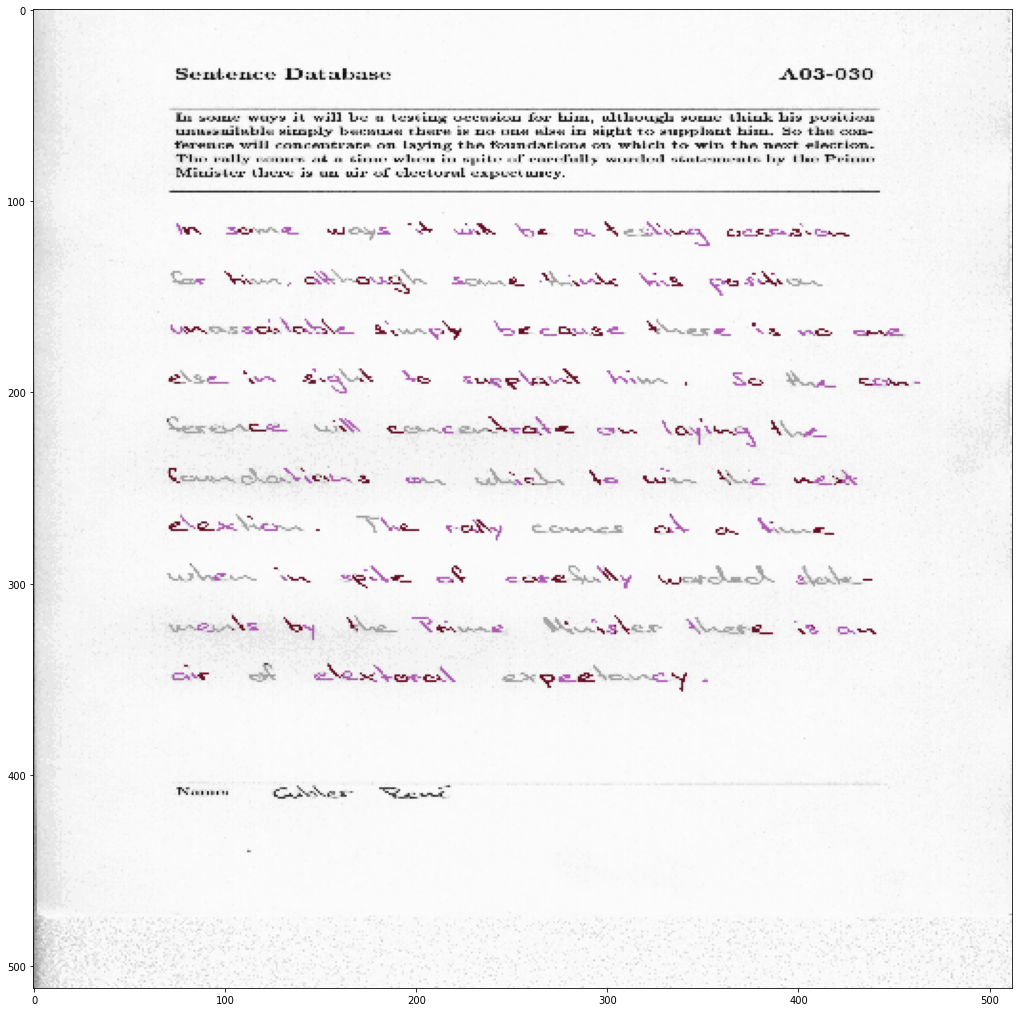

In [20]:
plt.figure(figsize=(18,18))
plt.imshow(get_image_masks(df_masks))
plt.show()